In [1]:
from datasets import load_dataset
dataset = load_dataset("rafaelpadilla/coco2017")
train_dataset = dataset["train"]
val_dataset = dataset["val"]

/home/zhangfaen/miniconda3/envs/qwen2-VL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels = ["None", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet", "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush", "hair brush"]
print(len(labels))
print(train_dataset[3].keys())
print(train_dataset[3])
print([(id, labels[id]) for id in range(len(labels))])

print(train_dataset[3]['image'].size)

92
dict_keys(['image', 'image_id', 'objects'])
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x365 at 0x147D2E8D09D0>, 'image_id': 63879, 'objects': {'id': [336129, 674780, 1142474, 1145089, 1158532], 'area': [4737.597749999999, 4254.8196499999995, 2210.926700000001, 4068.0025500000015, 2373.64885], 'bbox': [[467.8900146484375, 55.63999938964844, 101.25, 49.0], [364.6000061035156, 235.1199951171875, 64.02999877929688, 80.51000213623047], [225.7100067138672, 220.02999877929688, 57.5099983215332, 43.970001220703125], [34.369998931884766, 149.75999450683594, 55.650001525878906, 170.22999572753906], [110.55000305175781, 170.22999572753906, 60.459999084472656, 72.25]], 'label': [85, 47, 84, 84, 87], 'iscrowd': [False, False, False, False, False]}}
[(0, 'None'), (1, 'person'), (2, 'bicycle'), (3, 'car'), (4, 'motorcycle'), (5, 'airplane'), (6, 'bus'), (7, 'train'), (8, 'truck'), (9, 'boat'), (10, 'traffic light'), (11, 'fire hydrant'), (12, 'street sign'), (13, 'stop sig

In [3]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert

def show_image(img, bbox, label_ids, title=""):
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()
    tensor_image = to_tensor(img)
    if bbox is not None and label_ids is not None:
        bbox = box_convert(torch.Tensor(bbox), 'xywh', 'xyxy')
        tensor_image = draw_bounding_boxes(tensor_image, bbox, [labels[l] for l in label_ids], width=4)
    pil_image = to_pil(tensor_image)
    plt.imshow(pil_image)
    plt.title(title+str(img.size))
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()


def show_some_pics_with_bbox(dataset = train_dataset, num = 5):
    random_integers = [random.randint(0, len(train_dataset)) for _ in range(num)]
    for i in random_integers:
        show_image(train_dataset[i]["image"], train_dataset[i]["objects"]["bbox"], train_dataset[i]["objects"]["label"])

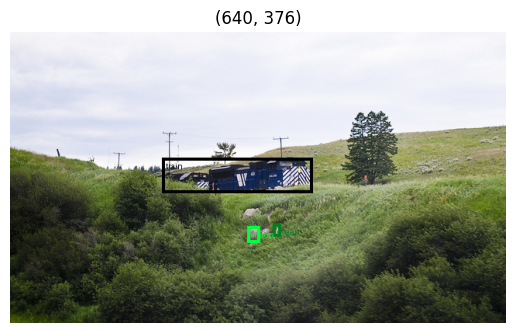

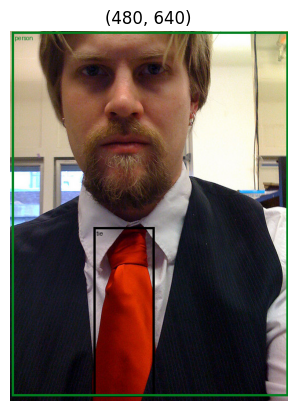

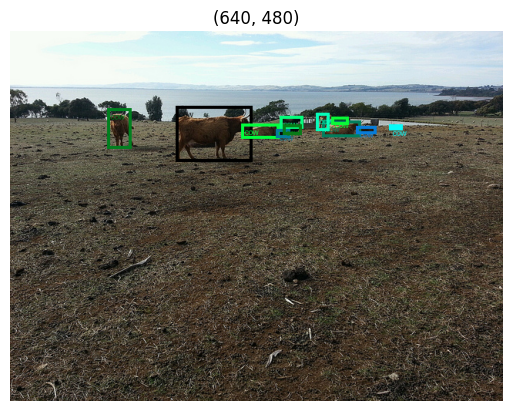

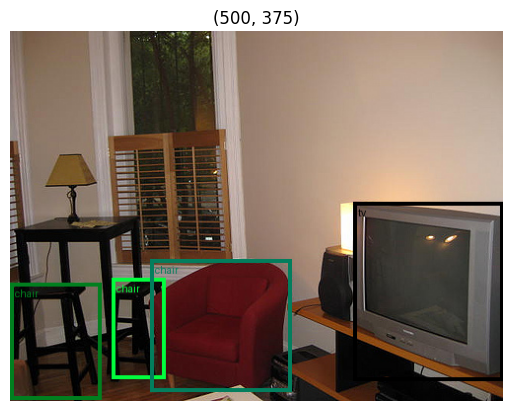

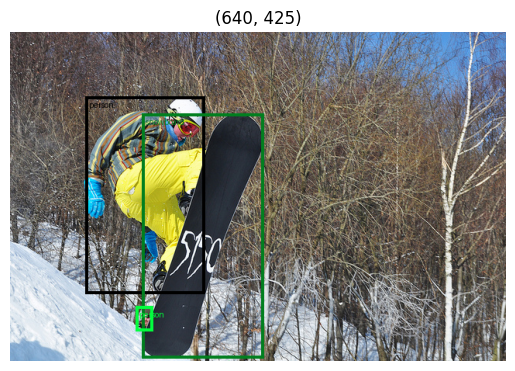

In [4]:
show_some_pics_with_bbox(train_dataset, 5)

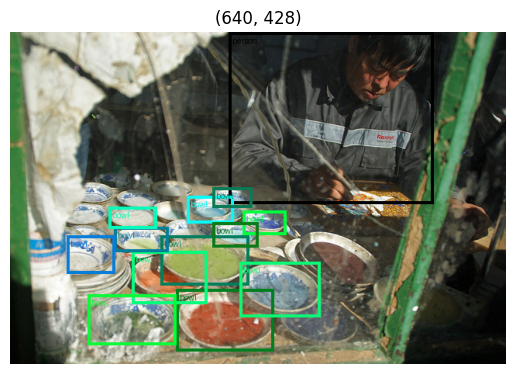

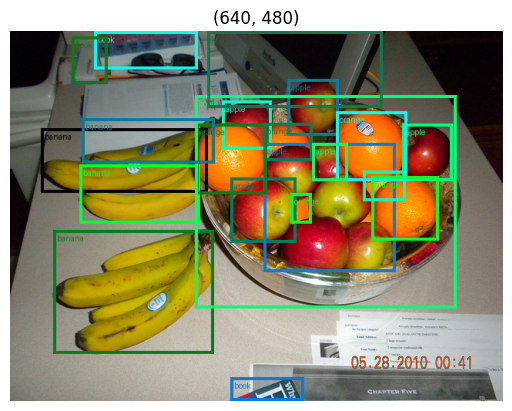

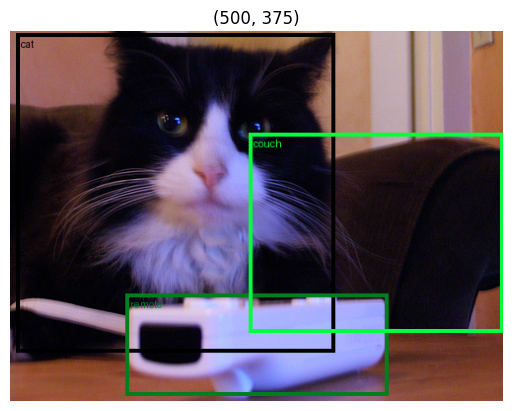

In [5]:
show_some_pics_with_bbox(val_dataset, 3)

In [7]:
import sys
sys.path.append("../util")  # TODO: fix this ugly import hack

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from vision_util import process_vision_info
from util.coco_dataloader import convert_token_ids_to_bbox_xyhw_and_label_id

model_dir = "train_output/20241012191056/checkpoint-epoch-9-steps-27000-loc_size-100-grad_accu-2-640X480-only"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_dir, torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_dir, min_pixels=256*28*28, max_pixels=256*28*28, padding_side="left")

def predicate_one_image(img):
    messages1 = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": img,
                },
                {"type": "text", "text": "描述一下这个图片，把其中的物体名称和位置标注出来"},
            ],
        }
    ]

    messages = [messages1]
    texts = [
        processor.apply_chat_template(msg, tokenize=False, add_generation_prompt=True)
        for msg in messages
    ]

    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=texts,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    # print(f"generated_ids: {generated_ids}")
    # print(f"generated tokens: {processor.tokenizer.decode(generated_ids[0])}")
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    print(f"generated_ids_trimmed: {generated_ids_trimmed}")

    # print(f"output_text: {output_text}")
    bbox, label_ids = convert_token_ids_to_bbox_xyhw_and_label_id(generated_ids_trimmed[0].tolist(), processor, (640, 480))
    print(bbox, label_ids)
    return bbox, label_ids

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


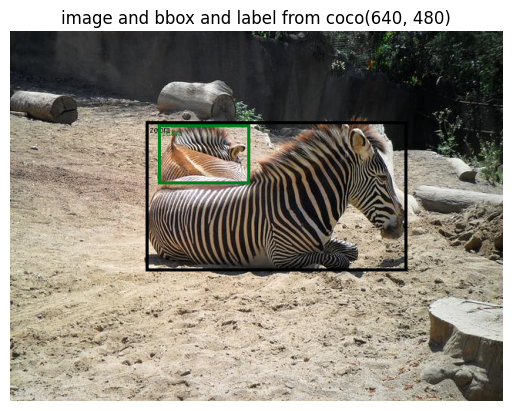

generated_ids_trimmed: [tensor([151474, 151569, 151566, 151621, 151613, 151474, 151575, 151568, 151603,
        151580, 151645], device='cuda:0')]
output_text: ['ῐ𝕡𝓾‴↷ῐ𝙮𝕍ㄧ𝙽']
[[172.8, 115.2, 332.8, 225.60000000000002], [211.2, 124.8, 179.2, 57.60000000000001]] [24, 24]


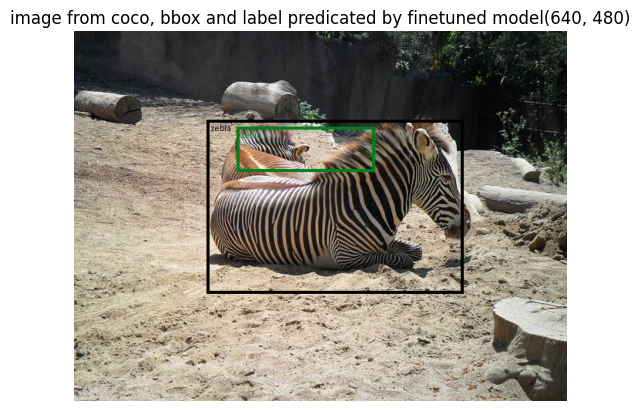

In [9]:
from PIL import Image

# { "id": [ 590587, 591955 ], "area": [ 40861.27974999998, 6793.037800000001 ], "bbox": [ [ 176.61000061035156, 117.55999755859375, 339.1499938964844, 193.9499969482422 ], [ 192, 121.08000183105469, 119.7300033569336, 77.66000366210938 ] ], "label": [ 24, 24 ], "iscrowd": [ false, false ] }
img = Image.open("../train_data/train_160437.jpg")
bbox_from_coco=[ [ 176.61000061035156, 117.55999755859375, 339.1499938964844, 193.9499969482422 ], [ 192, 121.08000183105469, 119.7300033569336, 77.66000366210938 ] ]
label_from_coco=[ 24, 24 ]

show_image(img, bbox_from_coco, label_from_coco, "image and bbox and label from coco")

bbox, label = predicate_one_image(img)
show_image(img, bbox, label, "image from coco, bbox and label predicated by finetuned model")

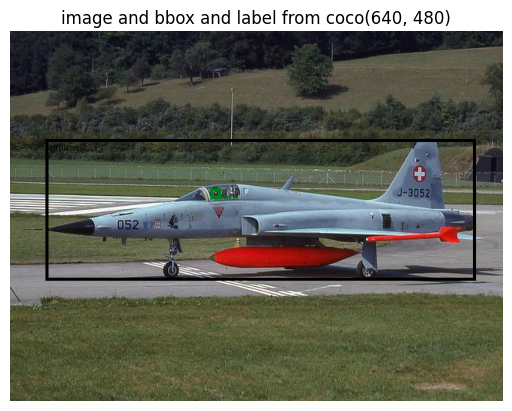

generated_ids_trimmed: [tensor([151455, 151549, 151570, 151640, 151613, 151645], device='cuda:0')]
output_text: ['ɘ틍𝕱⍨↷']
[[44.8, 134.4, 582.4000000000001, 206.4]] [5]


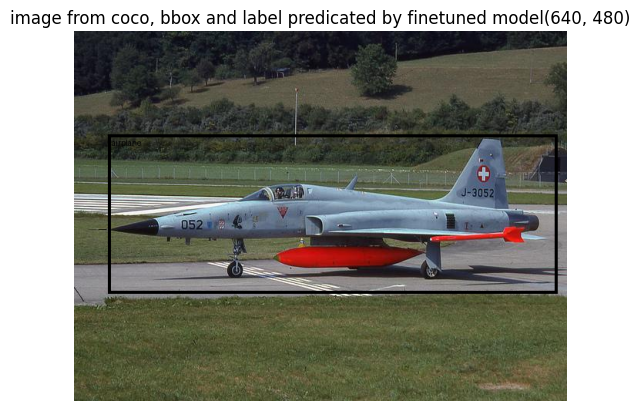

In [11]:
from PIL import Image

# train_image_id: 475693  
# "bbox": [ [ 46.279998779296875, 140.55999755859375, 558.5599975585938, 182.9600067138672 ], [ 260.79998779296875, 204.07000732421875, 12.779999732971191, 13.670000076293945 ] ], "label": [ 5, 1 ], "iscrowd": [ false, false ] }
img = Image.open("../train_data/train_475693.jpg")
bbox_from_coco=[ [ 46.279998779296875, 140.55999755859375, 558.5599975585938, 182.9600067138672 ], [ 260.79998779296875, 204.07000732421875, 12.779999732971191, 13.670000076293945 ] ]
label_from_coco=[ 5, 1 ]

show_image(img, bbox_from_coco, label_from_coco, "image and bbox and label from coco")

bbox, label = predicate_one_image(img)
show_image(img, bbox, label, "image from coco, bbox and label predicated by finetuned model")

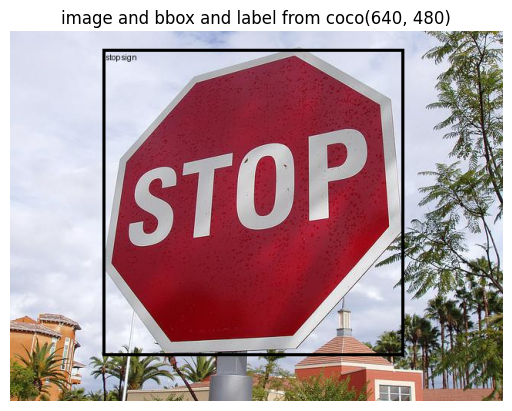

generated_ids_trimmed: [tensor([151463, 151564,  25209,    246, 151621, 151631, 151645],
       device='cuda:0')]
output_text: ['ሾ𝓬臘‴Ⱑ']
Invalid loc token: 25209
[] []


In [12]:
from PIL import Image

# { "id": [ 271630 ], "area": [ 117302.03975 ], "bbox": [ [ 120, 23.239999771118164, 391.3500061035156, 397.8399963378906 ] ], "label": [ 13 ], "iscrowd": [ false ] }
img = Image.open("../test_data/val_191471.jpg")
bbox_from_coco=[ [ 120, 23.239999771118164, 391.3500061035156, 397.8399963378906 ] ]
label_from_coco=[ 13 ]

show_image(img, bbox_from_coco, label_from_coco, "image and bbox and label from coco")

bbox, label = predicate_one_image(img)
# show_image(img, bbox, label, "image from coco, bbox and label predicated by finetuned model")
# show_image(img, bbox, label_ids)